# Capacitor sourcing workbook

Use this workflow to build a robust standard capacitor library that is resilient to marketplace fluctuation.

In [47]:
%load_ext autoreload
import sys
import octopart
sys.path.append("../")
import scottopart.constants
import scottopart.mpnmagic.capacitors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

octopart.logger.setLevel(20)  # disable annoying debug logs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1. Collect capacitor availability data from Octopart.

In [60]:
# Configure the query here.
AUTHORIZED_CAPACITOR_MANUFACTURERS = ['TDK', 'Murata', 'Yageo', 'KEMET', 'Taiyo Yuden', 'Samsung', 'AVX']
AUTHORIZED_SELLERS = ['Digi-Key', 'Newark', 'Mouser', 'Avnet', 'Arrow Electronics, Inc.']
AUTHORIZED_PACKAGING = ['Cut Tape', 'Tape & Reel', 'None']
query_package = ['0201', '0402', '0603']
query_capacitance = scottopart.constants.CAPACITOR_STANDARD_VALUES

# Convenience functions follow.
def search_octopart_for_capacitors(case_package, capacitance):
    """Search Octopart for capacitors.  Return PartsSearchResult."""
    # We would do this if we could:
    #     filter = {
    #         'manufacturer.displayname' : ['Murata', 'TDK', 'etc.']
    #         'specs.case_package.value' : '0603',
    #         'specs.capacitance.value'  : '4.7e-9'
    #     }
    #     r = octopart.search(query='', limit=100, filter_fields=filter, include_specs=True)
    # But the octopart Python API won't accept a list for manufacturer.displayname.
    # So this is our ugly workaround.
    c = octopart.client.OctopartClient()
    params = {
            'q': '', # leave blank
            'filter[fields][manufacturer.displayname][]': AUTHORIZED_CAPACITOR_MANUFACTURERS,
            'filter[fields][specs.capacitance.value][]': capacitance,
            'filter[fields][specs.case_package.value][]': case_package,
            'limit' : 100,
            'include[]' : 'specs',
    }
    r = octopart.models.PartsSearchResult(c._request('/parts/search', params=params))
    return r

# TODO: pick up authorized_* from a more sensible location
# TODO: figure out Digi-Key double-counting of in-stock quantity
def authorized_in_stock_qty(part):
    """Useful as a sorting key for a list of Part objects."""
    filtered_offers = [o for o in part.offers if o.seller in AUTHORIZED_SELLERS and o.packaging in AUTHORIZED_PACKAGING]
    return sum([o.in_stock_quantity for o in filtered_offers])

In [65]:
# Run the query.
print('Collecting data from Octopart...')
resultlist = []
for case_package in query_package:
    print('--- {} package ---'.format(case_package))
    for capacitance in query_capacitance:
        print(capacitance, end=' ')
        r = search_octopart_for_capacitors(case_package, capacitance)
        sorted_parts = sorted(r.parts, key=authorized_in_stock_qty, reverse=True)
        for p in sorted_parts:
            row = {}
            row['case_package'] = case_package
            row['capacitance'] = capacitance
            row['manufacturer'] = p.manufacturer
            row['mpn'] = p.mpn
            row['authorized_in_stock_qty'] = authorized_in_stock_qty(p)
            magic = scottopart.mpnmagic.capacitors.parse_mpn(p.mpn)
            if magic:
                row['manufacturer_series'] = magic.get('manufacturer_series', None)
                row['dielectric_characteristic'] = magic.get('dielectric_characteristic', None)
                row['voltage_rating_dc'] = magic.get('voltage_rating_dc', None)
                row['capacitance'] = magic.get('capacitance', capacitance)
                row['capacitance_tolerance'] = magic.get('capacitance_tolerance', None)
            resultlist.append(row)
    print('')
print('Done.')
df = pd.DataFrame(resultlist)
print('Results are in DataFrame "df".')

--- 0201 package ---
1e-12 1.5e-12 2.2e-12 3.3e-12 4.7e-12 6.8e-12 1e-11 1.2e-11 1.5e-11 1.8e-11 2.2e-11 2.7e-11 3.3e-11 3.9e-11 4.7e-11 5.6e-11 6.8e-11 8.2e-11 1e-10 1.2e-10 1.5e-10 1.8e-10 2.2e-10 2.7e-10 3.3e-10 3.9e-10 4.7e-10 5.6e-10 6.8e-10 8.2e-10 1e-09 1.2e-09 1.5e-09 1.8e-09 2.2e-09 2.7e-09 3.3e-09 3.9e-09 4.7e-09 5.6e-09 6.8e-09 8.2e-09 1e-08 1.2e-08 1.5e-08 1.8e-08 2.2e-08 2.7e-08 3.3e-08 3.9e-08 4.7e-08 5.6e-08 6.8e-08 8.2e-08 1e-07 1.2e-07 1.5e-07 1.8e-07 2.2e-07 2.7e-07 3.3e-07 3.9e-07 4.7e-07 5.6e-07 6.8e-07 8.2e-07 1e-06 2.2e-06 4.7e-06 1e-05 2.2e-05 4.7e-05 0.0001 
--- 0402 package ---
1e-12 1.5e-12 2.2e-12 3.3e-12 4.7e-12 6.8e-12 1e-11 1.2e-11 1.5e-11 1.8e-11 2.2e-11 2.7e-11 3.3e-11 3.9e-11 4.7e-11 5.6e-11 6.8e-11 8.2e-11 1e-10 1.2e-10 1.5e-10 1.8e-10 2.2e-10 2.7e-10 3.3e-10 3.9e-10 4.7e-10 5.6e-10 6.8e-10 8.2e-10 1e-09 1.2e-09 1.5e-09 1.8e-09 2.2e-09 2.7e-09 3.3e-09 3.9e-09 4.7e-09 5.6e-09 6.8e-09 8.2e-09 1e-08 1.2e-08 1.5e-08 1.8e-08 2.2e-08 2.7e-08 3.3e-08 3.9e-08 

In [67]:
# Save dataframe to CSV.
df.to_csv('capacitors-2018-09-05.csv')

## Step 2. Analyze!

In [2]:
# (optional)
# Read dataframe from CSV (in case you don't want to re-run the query.)
df = pd.read_csv('capacitors-2018-09-05.csv', index_col=[0], dtype={'case_package' : object})

### Step 2A. Choose parts to maximize stock.

In [173]:
# Optimization strategy: choose the voltage rating, dielectric, and tolerance based on highest in-stock qty.
strategy_maximize_stock = pd.DataFrame()

piv = pd.pivot_table(df, index=["case_package", "capacitance"], columns=["voltage_rating_dc"], values=["authorized_in_stock_qty"], aggfunc=np.sum)
strategy_maximize_stock['voltage_rating_dc'] = piv.idxmax(axis=1).apply(lambda x: x[1])

piv = pd.pivot_table(df, index=["case_package", "capacitance"], columns=["dielectric_characteristic"], values=["authorized_in_stock_qty"], aggfunc=np.sum)
strategy_maximize_stock['dielectric_characteristic'] = piv.idxmax(axis=1).apply(lambda x: x[1])

piv = pd.pivot_table(df, index=["case_package", "capacitance"], columns=["capacitance_tolerance"], values=["authorized_in_stock_qty"], aggfunc=np.sum)
strategy_maximize_stock['capacitance_tolerance'] = piv.idxmax(axis=1).apply(lambda x: x[1])

In [ ]:
strategy_maximize_stock

### Step 2B. Choose parts to maximize diversity of choices.

In [195]:
# Optimization strategy: choose the voltage rating, dielectric, and tolerance that offer the highest count
# of unique MPNs with qty > threshold.
qty_threshold = 50
strategy_maximize_choices = pd.DataFrame()

piv = pd.pivot_table(df[df['authorized_in_stock_qty'] > qty_threshold], index=["case_package", "capacitance"], columns=["voltage_rating_dc"], values=["mpn"], aggfunc=lambda x: x.value_counts().count())
strategy_maximize_choices['voltage_rating_dc'] = piv.idxmax(axis=1).apply(lambda x: x[1])

piv = pd.pivot_table(df[df['authorized_in_stock_qty'] > qty_threshold], index=["case_package", "capacitance"], columns=["dielectric_characteristic"], values=["mpn"], aggfunc=lambda x: x.value_counts().count())
strategy_maximize_choices['dielectric_characteristic'] = piv.idxmax(axis=1).apply(lambda x: x[1])

piv = pd.pivot_table(df[df['authorized_in_stock_qty'] > qty_threshold], index=["case_package", "capacitance"], columns=["capacitance_tolerance"], values=["mpn"], aggfunc=lambda x: x.value_counts().count())
strategy_maximize_choices['capacitance_tolerance'] = piv.idxmax(axis=1).apply(lambda x: x[1])


In [ ]:
strategy_maximize_choices

### Step 2C. Compare and manually adjust offline.

In [204]:
strategy_comparison = pd.concat([strategy_maximize_stock, strategy_maximize_choices], 
                   axis='columns', keys=['Strategy: Maximize Stock', 'Strategy: Maximize Choices'])

In [206]:
strategy_comparison.to_csv('strategy-comparison.csv')

In [14]:
# Q: For a given case_package and capacitance, what is the most common voltage rating?
g = df.groupby(['case_package', 'capacitance', 'voltage_rating_dc'])
g['authorized_in_stock_qty'].sum()
#.reset_index(drop=True)
#.capacitance_tolerance.value_counts().idxmax()
# What we'd like to do is return a dataframe with the capacitance as the index and columns for each value of voltage_rating_dc

case_package  capacitance   voltage_rating_dc
0201          1.000000e-12  10                         0
                            100                    49338
                            16                         0
                            25                   1333008
                            50                    121455
              1.500000e-12  10                         0
                            100                    24716
                            16                         0
                            25                    397657
                            50                    222821
              2.200000e-12  10                         0
                            100                     1790
                            16                         0
                            25                    306851
                            50                    142626
              3.300000e-12  10                         0
                            100           

case_package  capacitance   voltage_rating_dc
0201          1.000000e-12  10                         0
                            16                         0
                            25                   1333008
                            50                    121455
                            100                    49338
              1.500000e-12  10                         0
                            16                         0
                            25                    397657
                            50                    222821
                            100                    24716
              2.200000e-12  10                         0
                            16                         0
                            25                    306851
                            50                    142626
                            100                     1790
              3.300000e-12  10                         0
                            16            

In [16]:
# Q: For a given case_package and capacitance, what is the most common voltage rating?
g = df[df['case_package'] == '0201'].groupby(['capacitance', 'voltage_rating_dc'], as_index=False)
sg = g['authorized_in_stock_qty'].sum()
sg.groupby(['capacitance', 'voltage_rating_dc']).transform(max)

,authorized_in_stock_qty
0,0
1,49338
2,0
3,1333008
4,121455
5,0
6,24716
7,0
8,397657
9,222821


In [26]:
df = pd.DataFrame([
{'value' : 1e-12, 'C0G' : 23, 'X7R' : 55},
{'value' : 2.2e-12, 'C0G' : 32, 'X7R' : 45},
{'value' : 3.3e-12, 'C0G' : 11, 'X7R' : 20}
])

In [27]:
df

,C0G,X7R,value
0,23,55,1.000000e-12
1,32,45,2.200000e-12
2,11,20,3.300000e-12


In [28]:
dfb = df.set_index('value')

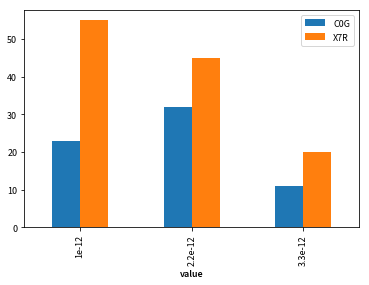

In [69]:
ax = dfb.plot.bar()

In [70]:
for t in ax.get_xticklabels():
    t.set_text('[{}]'.format(t.get_text()))

In [66]:
t.set_text()

'1e-12'

In [ ]:
ax.xaxis.set_major_formatter

In [16]:
df.head(1)

,authorized_in_stock_qty,capacitance,capacitance_tolerance,case_package,dielectric_characteristic,manufacturer,manufacturer_series,mpn,voltage_rating_dc
0,345764,1.000000e-12,±0.1pF,0201,C0G/NP0,Murata,GJM,GJM0335C1E1R0BB01D,25


In [165]:
piv = pd.pivot_table(df, index=["case_package", "capacitance"], columns=["dielectric_characteristic"], values=["authorized_in_stock_qty"], aggfunc=np.sum)
piv.idxmax(axis=1).apply(lambda x: x[1])

case_package  capacitance 
0201          1.000000e-12    C0G/NP0
              1.500000e-12    C0G/NP0
              2.200000e-12    C0G/NP0
              3.300000e-12    C0G/NP0
              4.700000e-12    C0G/NP0
              6.800000e-12    C0G/NP0
              1.000000e-11    C0G/NP0
              1.200000e-11    C0G/NP0
              1.500000e-11    C0G/NP0
              1.800000e-11    C0G/NP0
              2.200000e-11    C0G/NP0
              2.700000e-11    C0G/NP0
              3.300000e-11    C0G/NP0
              3.900000e-11    C0G/NP0
              4.700000e-11    C0G/NP0
              5.600000e-11    C0G/NP0
              6.800000e-11    C0G/NP0
              8.200000e-11    C0G/NP0
              1.000000e-10    C0G/NP0
              1.200000e-10    C0G/NP0
              1.500000e-10         JB
              1.800000e-10        X7R
              2.200000e-10        X7R
              2.700000e-10        X7R
              3.300000e-10        X7R
              3.900000e

In [166]:
strategy = pd.DataFrame()

In [167]:
strategy['dielectric'] = piv.idxmax(axis=1).apply(lambda x: x[1])

In [172]:
strategy

voltage_rating_dc dielectric_characteristic  \
case_package capacitance                                                
0201         1.000000e-12                25                   C0G/NP0   
             1.500000e-12                25                   C0G/NP0   
             2.200000e-12                25                   C0G/NP0   
             3.300000e-12                25                   C0G/NP0   
             4.700000e-12                25                   C0G/NP0   
             6.800000e-12                50                   C0G/NP0   
             1.000000e-11                50                   C0G/NP0   
             1.200000e-11                25                   C0G/NP0   
             1.500000e-11                25                   C0G/NP0   
             1.800000e-11                25                   C0G/NP0   
             2.200000e-11                25                   C0G/NP0   
             2.700000e-11                25                   C0G/NP0   
             3.300000e-11                50                   C0G/NP0   
             3.900000e-11                25                   C0G/NP0   
             4.700000e-11                25                   C0G/NP0   
             5.600000e-11                50                   C0G/NP0   
             6.800000e-11                25                   C0G/NP0   
             8.200000e-11                25                   C0G/NP0   
             1.000000e-10                25                   C0G/NP0   
             1.200000e-10                50                   C0G/NP0   
             1.500000e-10                25                        JB   
             1.800000e-10                25                       X7R   
             2.200000e-10                25                       X7R   
             2.700000e-10                16                       X7R   
             3.300000e-10                16                       X7R   
             3.900000e-10                16                       X7R   
             4.700000e-10                25                       X7R   
             5.600000e-10                16                       X7R   
             6.800000e-10                25                       X7R   
             8.200000e-10                25                       X7R   
...                                     ...                       ...   
0603         1.000000e-08                50                       X7R   
             1.200000e-08                16                       X7R   
             1.500000e-08                50                       X7R   
             1.800000e-08                50                       X7R   
             2.200000e-08                50                       X7R   
             2.700000e-08                50                       X7R   
             3.300000e-08                16                       X7R   
             3.900000e-08                16                       X7R   
             4.700000e-08                50                       X7R   
             5.600000e-08                16                       X7R   
             6.800000e-08                50                       X7R   
             8.200000e-08                16                       X7R   
             1.000000e-07                50                       X7R   
             1.200000e-07                10                       X7R   
             1.500000e-07                25                       X7R   
             1.800000e-07                10                       X7R   
             2.200000e-07                25                       X7R   
             2.700000e-07                16                       X7R   
             3.300000e-07                50                       X7R   
             3.900000e-07                10                       X7R   
             4.700000e-07                25                       X5R   
             5.600000e-07                10                       X5R   
           

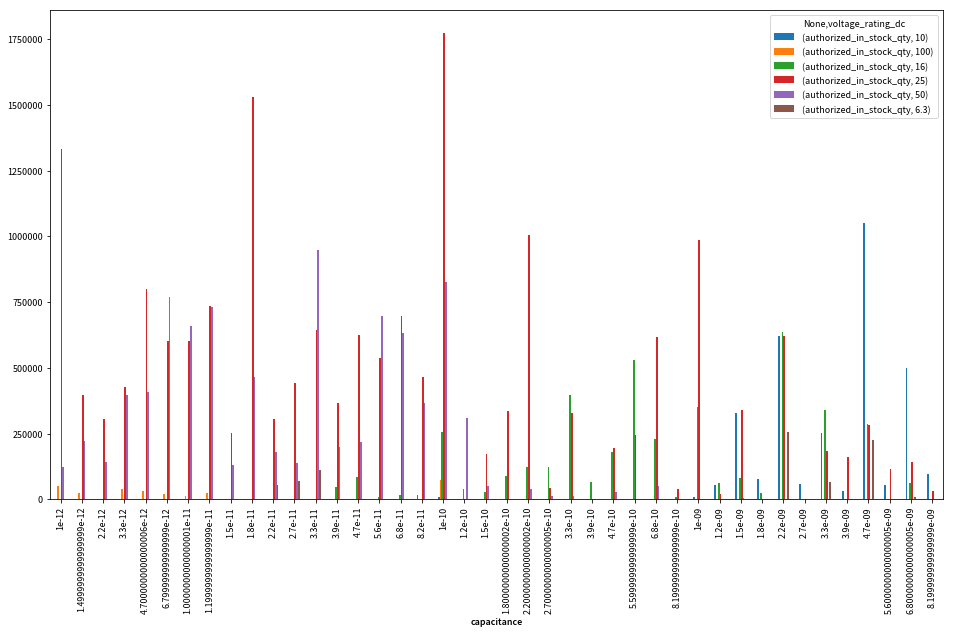

In [51]:
fig, ax = plt.subplots(figsize=(16,9))
piv.plot.bar(ax=ax)

In [24]:
df[df['voltage_rating_dc'] == 'YA' ]

,authorized_in_stock_qty,capacitance,capacitance_tolerance,case_package,dielectric_characteristic,manufacturer,manufacturer_series,mpn,voltage_rating_dc
3508,300000,1.000000e-07,10%,0201,X5R,Murata,GRM,GRM033R6YA104KE14D,YA
3514,123417,1.000000e-07,20%,0201,X5R,Murata,GRM,GRM033R6YA104ME14D,YA
9375,143,2.200000e-07,20%,0402,X6S,Murata,GRM,GRM155C8YA224ME01D,YA
9377,86,2.200000e-07,10%,0402,X6S,Murata,GRM,GRM155C8YA224KE01D,YA
9387,1,2.200000e-07,10%,0402,X5R,Murata,GRM,GRM155R6YA224KE01D,YA
9401,0,2.200000e-07,20%,0402,X5R,Murata,GRM,GRM155R6YA224ME01D,YA
9580,0,4.700000e-07,20%,0402,X5R,Murata,GRM,GRM155R6YA474ME01D,YA
9593,0,4.700000e-07,10%,0402,X5R,Murata,GRM,GRM155R6YA474KE01D,YA
9787,0,1.000000e-06,10%,0402,X5R,Murata,GRM,GRM155R6YA105KE11D,YA
9802,0,1.000000e-06,20%,0402,X5R,Murata,GRM,GRM155R6YA105ME11D,YA


In [39]:
piv2 = piv.reindex(columns=sorted(piv.columns, key=int))
#df = df.reindex(columns=(['opened'] + list([a for a in df.columns if a != 'opened']) ))

TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

In [37]:
df

,opened,authorized_in_stock_qty,capacitance,capacitance_tolerance,case_package,dielectric_characteristic,manufacturer,manufacturer_series,mpn,voltage_rating_dc
0,NaN,345764,1.000000e-12,±0.1pF,0201,C0G/NP0,Murata,GJM,GJM0335C1E1R0BB01D,25
1,NaN,300495,1.000000e-12,±0.1pF,0201,C0G/NP0,Samsung,CL,CL03C010BA3GNNC,25
2,NaN,229355,1.000000e-12,±0.05pF,0201,C0G/NP0,Murata,GJM,GJM0335C1E1R0WB01D,25
3,NaN,170586,1.000000e-12,±0.25pF,0201,C0G/NP0,TDK,C,C0603C0G1E010C030BA,25
4,NaN,95982,1.000000e-12,±0.1pF,0201,C0G/NP0,AVX,NaN,02013A1R0BAT2A,25
5,NaN,74290,1.000000e-12,±0.25pF,0201,CH,TDK,C,C0603CH1E010C030BA,25
6,NaN,49338,1.000000e-12,±0.25pF,0201,C0G/NP0,Murata,GRM,GRM0335C2A1R0CA01D,100
7,NaN,44750,1.000000e-12,±0.25pF,0201,CH,TDK,C,C0603CH1H010C030BA,50
8,NaN,22640,1.000000e-12,±0.05pF,0201,C0G/NP0,Murata,GRM,GRM0335C1H1R0WA01D,50
9,NaN,19725,1.000000e-12,±0.05pF,0201,C0G/NP0,Murata,GJM,GJM0335C1H1R0WB01E,50


In [4]:
import scottopart.tools

In [25]:
scottopart.tools.format_value(0.0005, unit='F', with_space=False)

'500uF'

In [8]:
import math

In [3]:
%autoreload 2

In [11]:
sep = ' ' if False else ''

In [12]:
sep

''

In [18]:
df['dielectric_characteristic'].unique()

array(['C0G/NP0', 'CH', nan, 'U2J', '6S', '6T', '6R', '4C', 'NP0', '6C',
       'X7R', '2C', '3U', 'X5R', 'JB', 'B1', 'R1', 'B3', 'F5', 'X6S',
       'Y5V', 'X7S', 'X7T', 'U', '6P', '3C', 'X8R', '1X', 'SL', 'SD',
       'L8', 'X6T', 'F1', 'C6', '5G', 'E', 'L'], dtype=object)

In [176]:
df.head(5)

,authorized_in_stock_qty,capacitance,capacitance_tolerance,case_package,dielectric_characteristic,manufacturer,manufacturer_series,mpn,voltage_rating_dc
0,345764,1.000000e-12,±0.1pF,0201,C0G/NP0,Murata,GJM,GJM0335C1E1R0BB01D,25
1,300495,1.000000e-12,±0.1pF,0201,C0G/NP0,Samsung,CL,CL03C010BA3GNNC,25
2,229355,1.000000e-12,±0.05pF,0201,C0G/NP0,Murata,GJM,GJM0335C1E1R0WB01D,25
3,170586,1.000000e-12,±0.25pF,0201,C0G/NP0,TDK,C,C0603C0G1E010C030BA,25
4,95982,1.000000e-12,±0.1pF,0201,C0G/NP0,AVX,NaN,02013A1R0BAT2A,25


In [191]:
pd.pivot_table(df[df['authorized_in_stock_qty'] > 50], index=["case_package", "capacitance"], columns=["voltage_rating_dc"], values=["mpn"], aggfunc=lambda x: x.value_counts().count())

mpn                                            \
voltage_rating_dc            10  100    16 2.5  200    25  250   35     4   
case_package capacitance                                                    
0201         1.000000e-12   NaN  1.0   NaN NaN  NaN  14.0  NaN  NaN   NaN   
             1.500000e-12   NaN  1.0   NaN NaN  NaN  13.0  NaN  NaN   NaN   
             2.200000e-12   NaN  1.0   NaN NaN  NaN  13.0  NaN  NaN   NaN   
             3.300000e-12   NaN  1.0   NaN NaN  NaN  11.0  NaN  NaN   NaN   
             4.700000e-12   NaN  1.0   NaN NaN  NaN  12.0  NaN  NaN   NaN   
             6.800000e-12   NaN  1.0   NaN NaN  NaN  12.0  NaN  NaN   NaN   
             1.000000e-11   NaN  1.0   NaN NaN  NaN  15.0  NaN  NaN   NaN   
             1.200000e-11   NaN  1.0   NaN NaN  NaN  16.0  NaN  NaN   NaN   
             1.500000e-11   NaN  NaN   NaN NaN  NaN  10.0  NaN  NaN   NaN   
             1.800000e-11   NaN  NaN   NaN NaN  NaN  16.0  NaN  NaN   NaN   
             2.200000e-11   NaN  NaN   NaN NaN  NaN  11.0  NaN  NaN   NaN   
             2.700000e-11   NaN  NaN   NaN NaN  NaN  12.0  NaN  NaN   NaN   
             3.300000e-11   NaN  NaN   NaN NaN  NaN  12.0  NaN  NaN   NaN   
             3.900000e-11   NaN  NaN   1.0 NaN  NaN  10.0  NaN  NaN   NaN   
             4.700000e-11   NaN  NaN   1.0 NaN  NaN  12.0  NaN  NaN   NaN   
             5.600000e-11   NaN  NaN   1.0 NaN  NaN  10.0  NaN  NaN   NaN   
             6.800000e-11   NaN  NaN   1.0 NaN  NaN  11.0  NaN  NaN   NaN   
             8.200000e-11   1.0  NaN   NaN NaN  NaN   8.0  NaN  NaN   NaN   
             1.000000e-10   1.0  1.0   2.0 NaN  NaN  20.0  NaN  NaN   NaN   
             1.200000e-10   NaN  NaN   2.0 NaN  NaN   NaN  NaN  NaN   NaN   
             1.500000e-10   NaN  NaN   3.0 NaN  NaN   8.0  NaN  NaN   NaN   
             1.800000e-10   NaN  NaN   2.0 NaN  NaN   2.0  NaN  NaN   NaN   
             2.200000e-10   NaN  NaN   6.0 NaN  NaN  11.0  NaN  NaN   NaN   
             2.700000e-10   NaN  NaN   3.0 NaN  NaN   2.0  NaN  NaN   NaN   
             3.300000e-10   NaN  NaN   4.0 NaN  NaN   8.0  NaN  NaN   NaN   
             3.900000e-10   NaN  NaN   2.0 NaN  NaN   NaN  NaN  NaN   NaN   
             4.700000e-10   NaN  NaN   5.0 NaN  NaN   8.0  NaN  NaN   NaN   
             5.600000e-10   NaN  NaN   3.0 NaN  NaN   4.0  NaN  NaN   NaN   
             6.800000e-10   NaN  NaN   2.0 NaN  NaN  10.0  NaN  NaN   NaN   
             8.200000e-10   NaN  NaN   1.0 NaN  NaN   3.0  NaN  NaN   NaN   
...                         ...  ...   ...  ..  ...   ...  ...  ...   ...   
0603         8.200000e-09   1.0  3.0   1.0 NaN  NaN   6.0  NaN  NaN   NaN   
             1.000000e-08   4.0  6.0   9.0 NaN  4.0  10.0  1.0  NaN   NaN   
             1.200000e-08   1.0  3.0   5.0 NaN  NaN   7.0  NaN  NaN   NaN   
             1.500000e-08   4.0  4.0   7.0 NaN  NaN   9.0  NaN  NaN   NaN   
             1.800000e-08   2.0  1.0   4.0 NaN  NaN  10.0  NaN  NaN   NaN   
             2.200000e-08   6.0  8.0   8.0 NaN  NaN  11.0  NaN  NaN   NaN   
             2.700000e-08   NaN  1.0   5.0 NaN  NaN   9.0  NaN  NaN   NaN   
             3.300000e-08   2.0  2.0  10.0 NaN  NaN  12.0  NaN  NaN   NaN   
             3.900000e-08   NaN  1.0   6.0 NaN  NaN   4.0  NaN  NaN   NaN   
             4.700000e-08   NaN  2.0   9.0 NaN  NaN  17.0  NaN  1.0   NaN   
             5.600000e-08   NaN  NaN   9.0 NaN  NaN   5.0  NaN  NaN   NaN   
             6.800000e-08   2.0  NaN  12.0 NaN  NaN   8.0  NaN  NaN   NaN   
             8.200000e-08   1.0  NaN   8.0 NaN  NaN   2.0  NaN  NaN   NaN   
             1.000000e-07   2.0  NaN   4.0 NaN  NaN  10.0  NaN  NaN   NaN   
             1.500000e-07   8.0  NaN   6.0 NaN  NaN  11.0  NaN  8.0   NaN   
             2.200000e-07  11.0  NaN  17.0 NaN  NaN  14.0  NaN  1.0   1.0   
             3.300000e-07   5.0  NaN  17.0 NaN  NaN  10.0  NaN  7.0   NaN   
             4.700000e-07  12.0  NaN  19.0 NaN  NaN  14.0  NaN  5.0   1.0   
             1.000000e-0

In [188]:
df[df['authorized_in_stock_qty'] > 100]

,authorized_in_stock_qty,capacitance,capacitance_tolerance,case_package,dielectric_characteristic,manufacturer,manufacturer_series,mpn,voltage_rating_dc
0,345764,1.000000e-12,±0.1pF,0201,C0G/NP0,Murata,GJM,GJM0335C1E1R0BB01D,25
1,300495,1.000000e-12,±0.1pF,0201,C0G/NP0,Samsung,CL,CL03C010BA3GNNC,25
2,229355,1.000000e-12,±0.05pF,0201,C0G/NP0,Murata,GJM,GJM0335C1E1R0WB01D,25
3,170586,1.000000e-12,±0.25pF,0201,C0G/NP0,TDK,C,C0603C0G1E010C030BA,25
4,95982,1.000000e-12,±0.1pF,0201,C0G/NP0,AVX,NaN,02013A1R0BAT2A,25
5,74290,1.000000e-12,±0.25pF,0201,CH,TDK,C,C0603CH1E010C030BA,25
6,49338,1.000000e-12,±0.25pF,0201,C0G/NP0,Murata,GRM,GRM0335C2A1R0CA01D,100
7,44750,1.000000e-12,±0.25pF,0201,CH,TDK,C,C0603CH1H010C030BA,50
8,22640,1.000000e-12,±0.05pF,0201,C0G/NP0,Murata,GRM,GRM0335C1H1R0WA01D,50
9,19725,1.000000e-12,±0.05pF,0201,C0G/NP0,Murata,GJM,GJM0335C1H1R0WB01E,50


In [189]:
df

,authorized_in_stock_qty,capacitance,capacitance_tolerance,case_package,dielectric_characteristic,manufacturer,manufacturer_series,mpn,voltage_rating_dc
0,345764,1.000000e-12,±0.1pF,0201,C0G/NP0,Murata,GJM,GJM0335C1E1R0BB01D,25
1,300495,1.000000e-12,±0.1pF,0201,C0G/NP0,Samsung,CL,CL03C010BA3GNNC,25
2,229355,1.000000e-12,±0.05pF,0201,C0G/NP0,Murata,GJM,GJM0335C1E1R0WB01D,25
3,170586,1.000000e-12,±0.25pF,0201,C0G/NP0,TDK,C,C0603C0G1E010C030BA,25
4,95982,1.000000e-12,±0.1pF,0201,C0G/NP0,AVX,NaN,02013A1R0BAT2A,25
5,74290,1.000000e-12,±0.25pF,0201,CH,TDK,C,C0603CH1E010C030BA,25
6,49338,1.000000e-12,±0.25pF,0201,C0G/NP0,Murata,GRM,GRM0335C2A1R0CA01D,100
7,44750,1.000000e-12,±0.25pF,0201,CH,TDK,C,C0603CH1H010C030BA,50
8,22640,1.000000e-12,±0.05pF,0201,C0G/NP0,Murata,GRM,GRM0335C1H1R0WA01D,50
9,19725,1.000000e-12,±0.05pF,0201,C0G/NP0,Murata,GJM,GJM0335C1H1R0WB01E,50
